In [1]:
# Create a plot that shows examples of various benchmarks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

### Benchmarks

In [2]:
# Load Qobs and all the benchmark sims
qobs_file = Path('./timeseries/hysets_08NB014.csv')
qsim_file = Path('./benchmarks/hysets_08NB014.csv')

qobs = pd.read_csv(qobs_file, index_col=0, parse_dates=True)
qsim = pd.read_csv(qsim_file, index_col=0, parse_dates=True)

In [3]:
# Get the scores
score_file = Path('benchmark_scores_summary.csv')
scores = pd.read_csv(score_file, index_col=[0, 1])

idx = pd.IndexSlice
basin_kges = scores.loc[ idx[['kge_cal','kge_val'], 'hysets_08NB014'], :]

In [4]:
# Replicate the cal/val split
flow_mask = qobs['streamflow'] >= 0
flow_dates = flow_mask.index
median_date = flow_dates[len(flow_dates) // 2]

# Specify the calculation and evaluation periods, as boolean masks
cal_mask = qobs.index <= median_date
val_mask = ~cal_mask 

In [5]:
# Replicate the rain_plus_melt flux
def rain_to_melt(
    data, precipitation="precipitation", temperature="temperature", snow_and_melt_temp=0.0, snow_and_melt_rate=3.0
):
    """Calculate snow accumulation and melt based on temperature thresholds.

    Parameters
    ----------
    data : pandas DataFrame
        Input data containing precipitation and temperature columns.
    precipitation : str, optional
        Name of the precipitation column in the input data. Default is 'precipitation'.
    temperature : str, optional'
        Name of the temperature column in the input data. Default is 'temperature'.
    snow_and_melt_temp : float, optional
        Temperature threshold for snow accumulation and melt. Default is 0.0 [C].
    snow_and_melt_rate : float, optional
        Snow melt rate if temperature above threshold. Default is 3.0 [mm/hour/degree C].

    Returns
    -------
    data : pandas DataFrame
        Input data with additional colu"mns for snow depth and rain plus melt.
    """

    # Docs: 3 degrees C is a conservative estimate (see e.g.: https://tc.copernicus.org/articles/17/211/2023/)

    # Check that melt rate is not negative
    if snow_and_melt_rate < 0:
        raise ValueError(f"Snow melt rate must be non-negative. Currently set to: {snow_and_melt_rate}.")

    # Run a really simple time-stepping scheme to account for snow accumulation and melt.
    # We'll deal with the time step implicitly, simply assuming that delta t = 1.
    # We can get away with Explicit Euler (Snew = Sold + snowfall - snowmelt) because fall
    # and melt are mutually exclusive: no problems with ad-hoc operator splitting here.
    snow_depth = []
    rain_plus_melt = []
    Sold = 0
    for _, row in data.iterrows():
        # Determine snowfall or melt
        if row[temperature] > snow_and_melt_temp:
            melt = np.min([Sold, snow_and_melt_rate * (row[temperature] - snow_and_melt_temp)])
            rain = row[precipitation]
            snow = 0
        else:
            melt = 0
            rain = 0
            snow = row[precipitation]

        # Update the snow pack
        Snew = Sold + snow - melt

        # Retain the values
        snow_depth.append(Snew)
        rain_plus_melt.append(rain + melt)

        # Prepare for the next time step
        Sold = Snew

    # Outputs
    data["snow_depth"] = snow_depth
    data["rain_plus_melt"] = rain_plus_melt

    return data

qobs = rain_to_melt(qobs, precipitation='total_precipitation_sum', temperature='temperature_2m_mean')

In [6]:
basin_kges

,,mean_flow,median_flow,monthly_mean_flow,monthly_median_flow,daily_mean_flow,daily_median_flow,rainfall_runoff_ratio_to_all,rainfall_runoff_ratio_to_annual,rainfall_runoff_ratio_to_monthly,rainfall_runoff_ratio_to_daily,rainfall_runoff_ratio_to_timestep,monthly_rainfall_runoff_ratio_to_monthly,monthly_rainfall_runoff_ratio_to_daily,monthly_rainfall_runoff_ratio_to_timestep,scaled_precipitation_benchmark,adjusted_precipitation_benchmark,adjusted_smoothed_precipitation_benchmark
metric,basin,,,,,,,,,,,,,,,,,
kge_cal,hysets_08NB014,NaN,NaN,0.820636,0.769725,0.853586,0.813723,-0.414214,-0.332556,0.59748,0.203190,0.203190,0.726197,-0.145814,-0.145814,0.203190,0.209218,0.820047
kge_val,hysets_08NB014,-0.414221,-0.580138,0.849259,0.799530,0.875609,0.838693,-0.414214,-0.323225,0.50131,0.120558,0.120558,0.686807,-0.276736,-0.276736,0.120558,0.128237,0.843016


### Model simulations

In [113]:
# Files
sim_folder = Path('./simulations')
model_sim_files = sorted(list(sim_folder.glob('*_qsim.csv')))
model_cal_kge_files = sorted(list(sim_folder.glob('*_cal_kge.csv')))
model_val_kge_files = sorted(list(sim_folder.glob('*_val_kge.csv')))

In [114]:
# Create a dataframe with cal/val KGE scores of each model
model_dfs = []
for cal_csv_file,val_csv_file in zip(model_cal_kge_files,model_val_kge_files):
    
    # Extract model ID and assert match
    mid_cal = cal_csv_file.name.split('_')[2]
    mid_val = val_csv_file.name.split('_')[2]
    assert mid_cal == mid_val
    
    # Load both CSVs
    cal_df = pd.read_csv(cal_csv_file,header=None)
    val_df = pd.read_csv(val_csv_file,header=None)
    
    # Rename the columns
    cal_df.columns = [f'parset{col+1}' for col in cal_df.columns] # col+1 so that we wend up with columns 1-5, to match Matlab output in simulation CSV files
    val_df.columns = [f'parset{col+1}' for col in val_df.columns]
    
    # Flip dataframes
    cal_df = cal_df.transpose()
    val_df = val_df.transpose()
    
    # Rename the now new column
    cal_df.columns = [mid_cal]
    val_df.columns = [mid_val]
    
    # Insert the first level of the multiindex
    cal_df.index = pd.MultiIndex.from_product([['kge_cal'], cal_df.index], names=['metric', 'par_set'])
    val_df.index = pd.MultiIndex.from_product([['kge_val'], val_df.index], names=['metric', 'par_set'])

    # Merge vertically and retain
    model_dfs.append(pd.concat([cal_df,val_df]))

# Create single df and sort columns while we're at it
model_kges = pd.concat(model_dfs,axis=1).sort_index(axis=1)

In [115]:
model_kges

m06       m12       m30       m34       m37
metric  par_set                                                  
kge_cal parset1  0.547566  0.699239  0.803105  0.773552  0.767622
        parset2  0.547566  0.547566  0.798168  0.773553  0.776918
        parset3  0.547566  0.547566  0.803104  0.773467  0.776729
        parset4  0.696090  0.547566  0.798168  0.772500  0.777025
        parset5  0.693684  0.547187  0.798168  0.772584  0.775725
kge_val parset1  0.556549  0.712007  0.832386  0.781644  0.802465
        parset2  0.556549  0.556552  0.824685  0.781580  0.810181
        parset3  0.556554  0.556550  0.832402  0.781788  0.810274
        parset4  0.708619  0.556550  0.824682  0.784485  0.810347
        parset5  0.707192  0.556524  0.824686  0.784926  0.813276

In [146]:
# Select the best parameter set per model, based on validation KGE
get_these_par_sets = model_kges.loc['kge_val'].idxmax()
model_max_kges = model_kges.loc['kge_val'].max()

In [127]:
# Read the model Qsim files, and select the appropriate Qsim for each model
sim_dfs = []
for csv_file in model_sim_files:
    
    # Extract model ID and assert match
    mid = csv_file.name.split('_')[2]
    
    # Find which parameter set we want for this model
    sim_id = get_these_par_sets[mid]
    
    # Load the simulations and select just the one we want
    model_sims = pd.read_csv(csv_file,index_col=0,parse_dates=True)
    model_sim = model_sims[sim_id]
    
    # swap the header name to be the model id
    model_sim.name = mid
    sim_dfs.append(model_sim)

# Merge into one df
qsim_model = pd.concat(sim_dfs,axis=1).sort_index(axis=1)

### Figure

In [148]:
model_max_kges['m06']

0.708618533816321

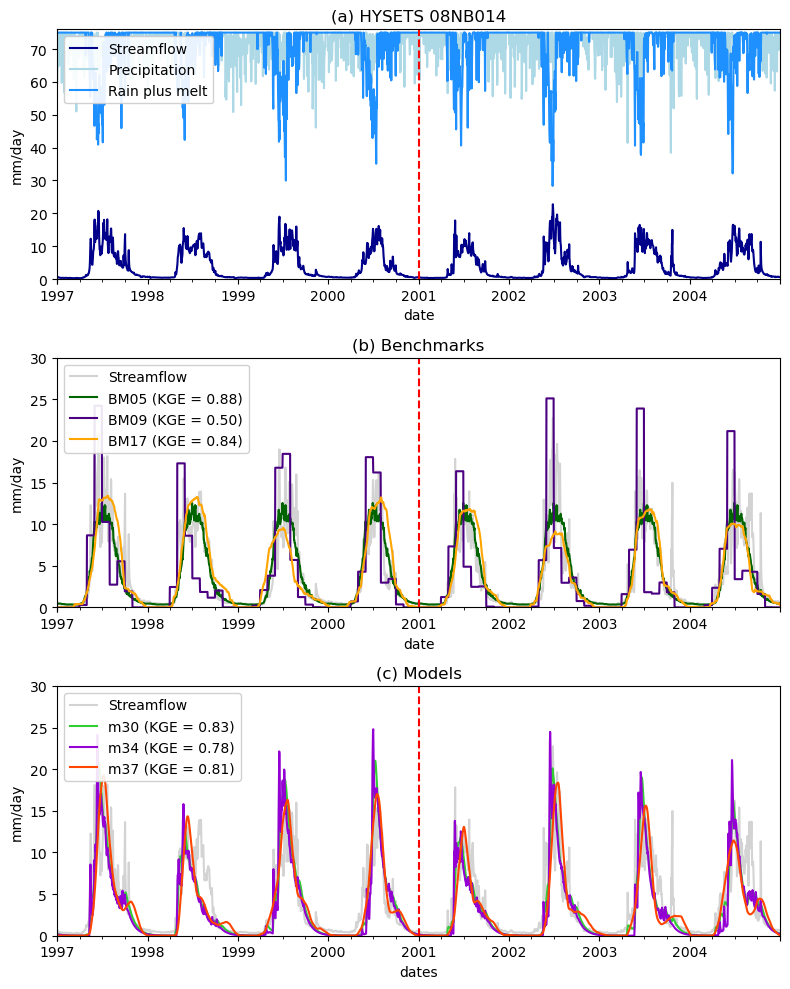

In [172]:
fig, axs = plt.subplots(3,1,figsize=(8,10))

# General settings
leg_loc = 'upper left'
leg_alpha = .9
n = 4
xlims = [median_date - pd.DateOffset(years=n), median_date + pd.DateOffset(years=n)]

# Data
ax = axs[0]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='darkblue')
(75-qobs['total_precipitation_sum']).plot(ax=ax, label='Precipitation', color='lightblue')
(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='dodgerblue')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha)
ax.set_title('(a) HYSETS 08NB014')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)
ax.set_ylim([0,76])

# Benchmarks
val1 = basin_kges['daily_mean_flow'].kge_val.values[0] # Q-only benchmark
lbl1 = f'BM05 (KGE = {val1:.2f})'
val2 = basin_kges['rainfall_runoff_ratio_to_monthly'].kge_val.values[0] # RR-benchmark
lbl2 = f'BM09 (KGE = {val2:.2f})'
val3 = basin_kges['adjusted_smoothed_precipitation_benchmark'].kge_val.values[0] # Calibrated benchmarks
lbl3 = f'BM17 (KGE = {val3:.2f})'

ax = axs[1]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='lightgrey')
#(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='lightsteelblue')
qsim['bm_daily_mean_flow'].plot(ax=ax, label=lbl1, color='darkgreen')
qsim['bm_rainfall_runoff_ratio_to_monthly'].plot(ax=ax, label=lbl2, color='indigo')
qsim['bm_adjusted_smoothed_precipitation_benchmark'].plot(ax=ax, label=lbl3, color='orange')
ax.axvline(median_date, color='r', linestyle='--')
ax.legend(loc=leg_loc, framealpha=leg_alpha, ncol=1)
ax.set_title('(b) Benchmarks')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)
ax.set_ylim([0,30])

# Model results
mval1 = model_max_kges['m06']
mlbl1 = f'm06 (KGE = {mval1:.2f})' #mlbl1 = f'm06: 2 stores,  4 parameters (KGE = {mval1:.2f})'
mval2 = model_max_kges['m12']
mlbl2 = f'm12 (KGE = {mval2:.2f})' #mlbl2 = f'm12: 2 stores,  6 parameters (KGE = {mval2:.2f})'
mval3 = model_max_kges['m30']
mlbl3 = f'm30 (KGE = {mval3:.2f})' #mlbl3 = f'm30: 5 stores,  7 parameters (KGE = {mval3:.2f})'
mval4 = model_max_kges['m34']
mlbl4 = f'm34 (KGE = {mval4:.2f})' #mlbl4 = f'm34: 5 stores, 12 parameters (KGE = {mval4:.2f})'
mval5 = model_max_kges['m37']
mlbl5 = f'm37 (KGE = {mval5:.2f})' #mlbl5 = f'm37: 5 stores, 15 parameters (KGE = {mval5:.2f})'

ax = axs[2]
qobs['streamflow'].plot(ax=ax, label='Streamflow', color='lightgrey')
#(75-qobs['rain_plus_melt']).plot(ax=ax, label='Rain plus melt', color='lightsteelblue')
#qsim_model.plot(ax=ax, cmap='Set2') # all five models
qsim_model['m30'].plot(ax=ax, label=mlbl3, color='limegreen')
qsim_model['m34'].plot(ax=ax, label=mlbl4, color='darkviolet')
qsim_model['m37'].plot(ax=ax, label=mlbl5, color='orangered')
#qobs['streamflow'].plot(ax=ax, label='Streamflow', color='darkblue')
ax.axvline(median_date, color='r', linestyle='--')
#ax.legend([mlbl1,mlbl2,mlbl3,mlbl4,mlbl5], loc=leg_loc, framealpha=leg_alpha)
ax.legend(loc=leg_loc, framealpha=leg_alpha, ncol=1)
ax.set_title('(c) Models')
ax.set_ylabel('mm/day')
ax.set_xlim(xlims)
ax.set_ylim([0,30])


plt.tight_layout()
file_name = Path('./paper_plots/benchmark_and_model_example.png')
plt.savefig(file_name, bbox_inches='tight', dpi=300)